## Easy run on colab
Open this notebook in colab (dev-branch) [![Quick run in Colab (dev-ветка)](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/82492749123082/farich-pics/blob/dev/notebooks/CirclesNN.ipynb) 

[by this discussion](https://gist.github.com/iamtekeste/3cdfd0366ebfd2c0d805)

In [1]:
!git clone https://github.com/82492749123082/farich-pics.git -b dev_nikitap #clone dev-branch
%cd farich-pics
!pip install gdown -q #install package

Cloning into 'farich-pics'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 383 (delta 24), reused 78 (delta 12), pack-reused 289
Receiving objects: 100% (383/383), 4.33 MiB | 3.81 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/farich-pics


In [0]:
url_dataset, dataset_path = "1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV", "dataset.pkl" #many circles dataset
# url_dataset, dataset_path = "1_Fm3mRAlioL3sCO0Gm9elb7fVa-KugkO", "dataset.pkl" #one circle dataset
url_nn, path_nn = "1gQtXr_WBY54sFpwNK-XLISqGiPMyzVvj", "nn.pth"

In [3]:
# !gdown --id $url_dataset -O $dataset_path
!gdown --id $url_nn -O $path_nn

Downloading...
From: https://drive.google.com/uc?id=1gQtXr_WBY54sFpwNK-XLISqGiPMyzVvj
To: /content/farich-pics/nn.pth
176MB [00:03, 45.5MB/s]


## Defining the Dataset



We have prepared dataset with `farich.DataPreprocessing`

Let's see on that

In [4]:
!pip install uproot -q

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 92kB 6.1MB/s 


In [34]:
from farichlib.DataPreprocessing import DataPreprocessing
import pickle

dp = DataPreprocessing(True)
H, y, masks = dp.generate_boards_randnum(100, 3, 1000)
with open(dataset_path, "wb") as f:
    pickle.dump((H, y, masks), f)

Generate toy boards
dss


In [0]:
import pickle

with open(dataset_path, "rb") as f:
    H_res, h_res, mask_res = pickle.load(f)

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Ellipse, Circle, Rectangle

%matplotlib inline

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


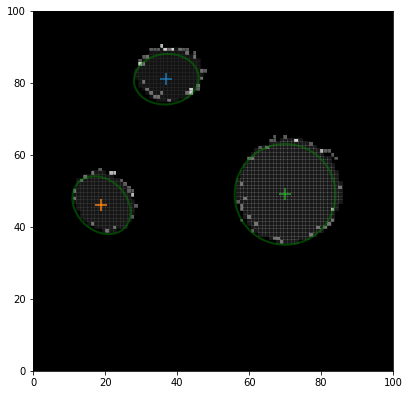

In [48]:
# loc_ind = 233
loc_ind +=1

coords = h_res[loc_ind]
H = H_res[loc_ind].toarray()

fig = plt.figure(frameon=False, figsize=(5,5))
ax = plt.Axes(fig, [0., 0., 1., (H.shape[1]/H.shape[0])])
fig.add_axes(ax)

xedges = np.linspace(0, H.shape[0], H.shape[0])
yedges = np.linspace(0, H.shape[1], H.shape[1])
Xg, Yg = np.meshgrid(xedges, yedges)
ax.pcolormesh(Xg, Yg, H, cmap='gray')

for m in mask_res[loc_ind]:
    ax.pcolormesh(Xg, Yg, m.toarray(), cmap='gray', alpha=0.1)

# print(coords)
for x,y,r,a,b in coords:
    e = Ellipse((x,y), 2*r, 2*a, b*180/np.pi, linewidth=2, fill=False, edgecolor='green', alpha=0.5)
    # e = Circle(xy=(x, y), radius=r, linewidth=2, fill=False, edgecolor='green', alpha=0.5)
    ax.add_artist(e)
    plt.scatter(x, y, marker='+', s=150)

Prepare dataset with `farichlib.Dataset` to pytorch style

In [0]:
import torch
from farichlib.Dataset import Dataset

In [50]:
data = Dataset(noise_level=0.1) #add noise to data
data.load(dataset_path)

torch.Size([1000, 100, 100])
torch.Size([1000, 100, 100])


In [51]:
data[0] #check

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'area': tensor([248.5772, 412.2679]),
  'boxes': tensor([[30.5634, 13.3451, 43.4366, 32.6549],
          [60.6877, 21.2578, 87.3123, 36.7422]]),
  'image_id': tensor([0]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
          

## Defining the model

Upload pretrained model

In [0]:
import torchvision
import math
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model(load_trained=None):
    if load_trained is None:
        num_classes = 2
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
        return model
    return torch.load(load_trained)

In [0]:
model = get_model(path_nn) #use pretrained model on noiseless data

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions


In [0]:
from farichlib import utils

In [0]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train(mode=True)
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [0]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(data)).tolist()
dataset = torch.utils.data.Subset(data, indices[:500]) #yes, only 500 images in train set | but it's enough
dataset_test = torch.utils.data.Subset(data, indices[500:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 1 epochs, (no) evaluating at the end of every epoch.

In [0]:
# let's train it for 1 epoch
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch+1, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [1]  [  0/250]  eta: 0:06:25  lr: 0.005000  loss: 0.2907 (0.2907)  loss_classifier: 0.0571 (0.0571)  loss_box_reg: 0.0681 (0.0681)  loss_mask: 0.1554 (0.1554)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0100 (0.0100)  time: 1.5412  data: 0.2929  max mem: 2145


Now that training has finished, let's have a look at what it actually predicts in a test image

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

Let's inspect the image and the predicted segmentation masks.

In [0]:
from farichlib.utils import iou_score, show_nn_result

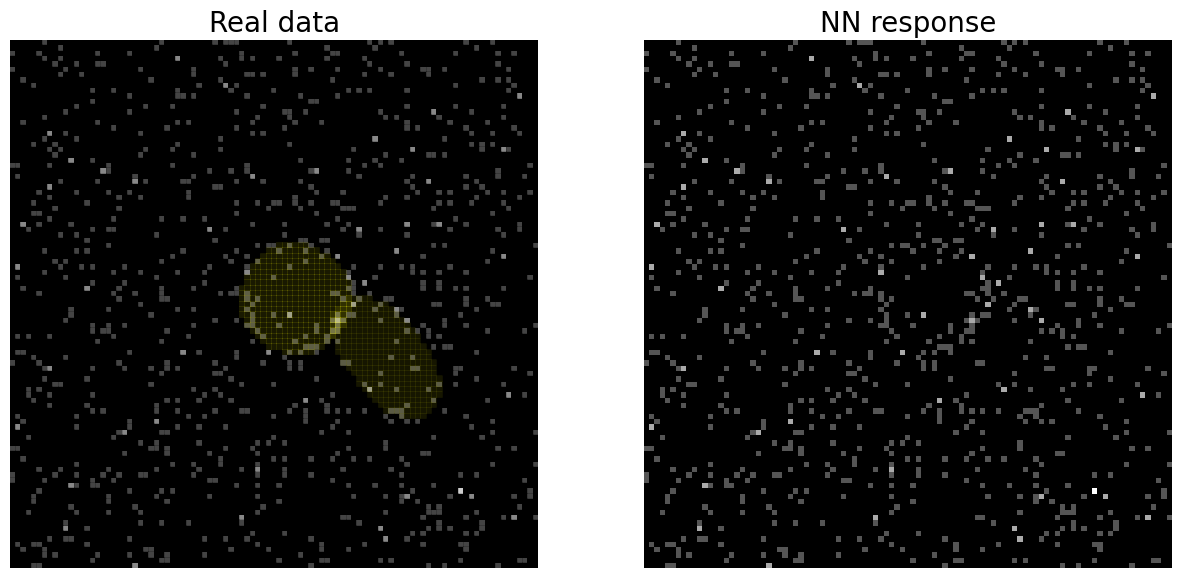

In [96]:
ind = random.randint(0, len(dataset_test)-1)
show_nn_result(model, dataset_test[ind], 0.99)

##Save entire model ([guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [0]:
# torch.save(model, '/content/drive/Shared drives/ML&HEP/data/CirclesNN_040420.pth')

## Some analytics
Works only for __one circle__ dataset

Объявляю следующие условия:
* TP: круг найден с IOU > 0.8
* FP: круг найден с IOU < 0.8
* FN: круг не найден, но он есть
* TN: круга нет и он не найден

In [0]:
def iou_score2(mask1, masks2):
    masks1 = np.broadcast_to(mask1, masks2.shape)
    inter = np.logical_and(masks1, masks2).sum(axis=(1,2))
    union = np.logical_or(masks1, masks2).sum(axis=(1,2))
    return inter/union

In [0]:
def iou_imgage(index, thresholds=np.linspace(0,1,10)):
    img, bbox = data[index+500]
    mask1 = bbox['masks'][0].numpy().astype('bool')
    model.eval()
    prediction = model([img.to(device)])
    # print(img.sum())
    try:
        masks2 = (prediction[0]['masks'][:,0].cpu().detach().numpy() > 0.5).astype('bool')
        scores = prediction[0]['scores'].cpu().detach().numpy()
    except:
        return np.array([[]])
    rates = np.vstack( (iou_score2(mask1, masks2), scores ) ).T
    return rates

In [0]:
n_images = 100
iou_thresh = 0.8
r = np.concatenate([ iou_imgage(i) for i in range(n_images)])

In [0]:
TP_FN = r[r[:,0]>iou_thresh][:,1]
FP = r[r[:,0]<iou_thresh][:,1]

In [0]:
threshold = np.linspace(0, 0.999, 1000)
TP0 = (TP_FN.reshape((-1,1))>threshold).sum(axis=0)
FN0 = np.where( n_images - TP0 > 0, n_images - TP0, 0 )
FP0 = (FP.reshape((-1,1))>threshold).sum(axis=0)
TN0 = np.zeros(threshold.shape, dtype=int)

In [0]:
precision = TP0/(TP0+FP0)
recall = TP0/(TP0+FN0)

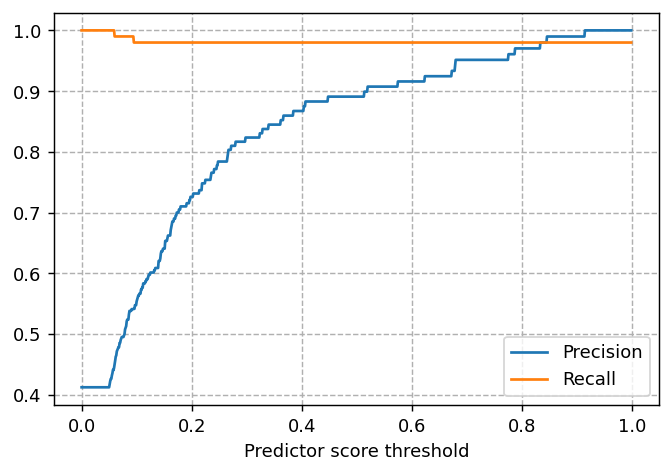

In [0]:
plt.figure(dpi=130)
plt.plot(threshold, precision, label='Precision')
plt.plot(threshold, recall, label='Recall')
plt.grid(linestyle='--')
plt.xlabel('Predictor score threshold')
plt.legend()